# Entrenemos un classificador!!!

In [1]:
# estas lineas magicas.. es para que recarge librerias si se actualizan.. o si tenemos codigo nuestro y hacemos import.. y lo modificamos tambien lo tome
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Instalacion de dependencias

In [ ]:
!pip install fastai --upgrade
#!pip install -Uqq fastbook
#torch torchvision.. 

## imports 1. 

In [3]:
!pip show fastai

Name: fastai
Version: 2.5.2
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: pip, fastprogress, fastcore, pandas, pillow, scipy, requests, pyyaml, scikit-learn, torch, spacy, matplotlib, packaging, torchvision, fastdownload
Required-by: 


In [ ]:
!pip show torch

Name: torch
Version: 1.9.0+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, fastai


In [4]:
import fastai; fastai.__version__

'2.5.2'

In [5]:
if int(fastai.__version__[0])>1:
  from fastai.vision.widgets import *
from fastai.vision import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback import *

from pathlib import Path
import os

## Cargo mis imagenes

In [ ]:
pwd

'/content'

In [6]:
%cd /content
!gdown --id 11b2nMHuW-hKerzbGyenOoV4Twjrhg2vu

/content
Downloading...
From: https://drive.google.com/uc?id=11b2nMHuW-hKerzbGyenOoV4Twjrhg2vu
To: /content/DatasetPerrosGatosSapos.zip
100% 150M/150M [00:00<00:00, 170MB/s]


In [7]:
# descarge las imagenes
!unzip DatasetPerrosGatosSapos.zip -d data

Archive:  DatasetPerrosGatosSapos.zip
   creating: data/gato/
  inflating: data/gato/00000001_000.jpg  
  inflating: data/gato/00000001_005.jpg  
  inflating: data/gato/00000001_008.jpg  
  inflating: data/gato/00000001_011.jpg  
  inflating: data/gato/00000001_012.jpg  
  inflating: data/gato/00000001_016.jpg  
  inflating: data/gato/00000001_017.jpg  
  inflating: data/gato/00000001_020.jpg  
  inflating: data/gato/00000001_024.jpg  
  inflating: data/gato/00000001_027.jpg  
  inflating: data/gato/00000001_029.jpg  
  inflating: data/gato/00000002_001.jpg  
  inflating: data/gato/00000002_003.jpg  
  inflating: data/gato/00000002_008.jpg  
  inflating: data/gato/00000002_026.jpg  
  inflating: data/gato/00000003_007.jpg  
  inflating: data/gato/00000003_009.jpg  
  inflating: data/gato/00000003_012.jpg  
  inflating: data/gato/00000003_013.jpg  
  inflating: data/gato/00000003_015.jpg  
  inflating: data/gato/00000003_020.jpg  
  inflating: data/gato/00000003_024.jpg  
  inflating: d

In [8]:
#vemos un poco las imagenes...
path = Path()/'data'
fns = get_image_files(path)
failed = verify_images(fns)

['gato', 'perro', 'sapo']


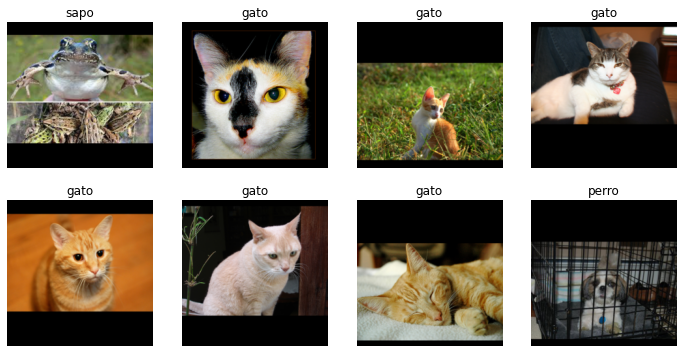

In [9]:
# CARGO mis imagenes
trucks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(224,ResizeMethod.Pad, pad_mode='zeros')
    # batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()],

    )
dls = trucks.dataloaders(path)
print(dls.vocab)
dls.train.show_batch(max_n=8, nrows=2)


In [ ]:
# otra opcion para cargar las imagenes puede ser
# si no le indico el valid_pct... espera tener dentro del path las subcarpetas train y valid
#data = ImageDataBunch.from_folder(path, size=416, valid_pct=.2,num_workers=4).normalize(imagenet_stats)

### opcionales

In [ ]:
# trucks = trucks.new(item_tfms=Resize(224, ResizeMethod.Squish))
# dls = trucks.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

# trucks = trucks.new(item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
# dls = trucks.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

# trucks = trucks.new(item_tfms=RandomResizedCrop(224, min_scale=0.3))
# dls = trucks.dataloaders(path)
# dls.train.show_batch(max_n=4, nrows=1, unique=True)

# trucks = trucks.new(item_tfms=Resize(224), batch_tfms=aug_transforms())
# dls = trucks.dataloaders(path)
# dls.train.show_batch(max_n=8, nrows=2, unique=True)

# trucks = trucks.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())
# dls = trucks.dataloaders(path)
# dls.train.show_batch(max_n=8, nrows=2, unique=True)

## ENTRENAMIENTO.. PARTE 1

In [ ]:
model_type = resnet18#34/50/101/152
defaults.device = torch.device('cuda') # makes sure the gpu is used

learn = cnn_learner(dls, model_type, metrics=error_rate)#accuracy

monitors = ["valid_loss","mse_loss","error_rate", "accuracy"]
monitor = monitors[0]
# para que no siga entrenarndo... si ya no hay cambios.. mse_loss / valid_loss
early_stop = EarlyStoppingCallback(monitor=monitor, min_delta=0.1, patience=5)
#opcionses de salvado del modelo.. sin nada.. es el mejor..
save_best_model = SaveModelCallback(monitor=monitor, fname='best_resnet18')
cbs = [early_stop, save_best_model]

#vemos el modelo..
learn.model

In [11]:
#frozen training step -> SOLO LA FULLY CONNECTED NWTWOK
learn.fit_one_cycle(4, cbs=cbs)

epoch,train_loss,valid_loss,error_rate,time
0,1.006423,0.080376,0.030534,00:14
1,0.478886,0.077505,0.019084,00:13
2,0.300497,0.063635,0.019084,00:13
3,0.201321,0.061758,0.015267,00:13


Better model found at epoch 0 with valid_loss value: 0.08037631213665009.
Better model found at epoch 1 with valid_loss value: 0.07750458270311356.
Better model found at epoch 2 with valid_loss value: 0.0636347234249115.
Better model found at epoch 3 with valid_loss value: 0.06175750121474266.


### Evaluamos

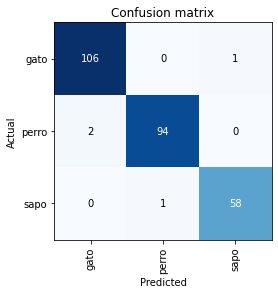

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
losses,idxs = interp.top_losses()
# len(data.valid_ds)==len(losses)==len(idxs)

[('perro', 'gato', 2)]

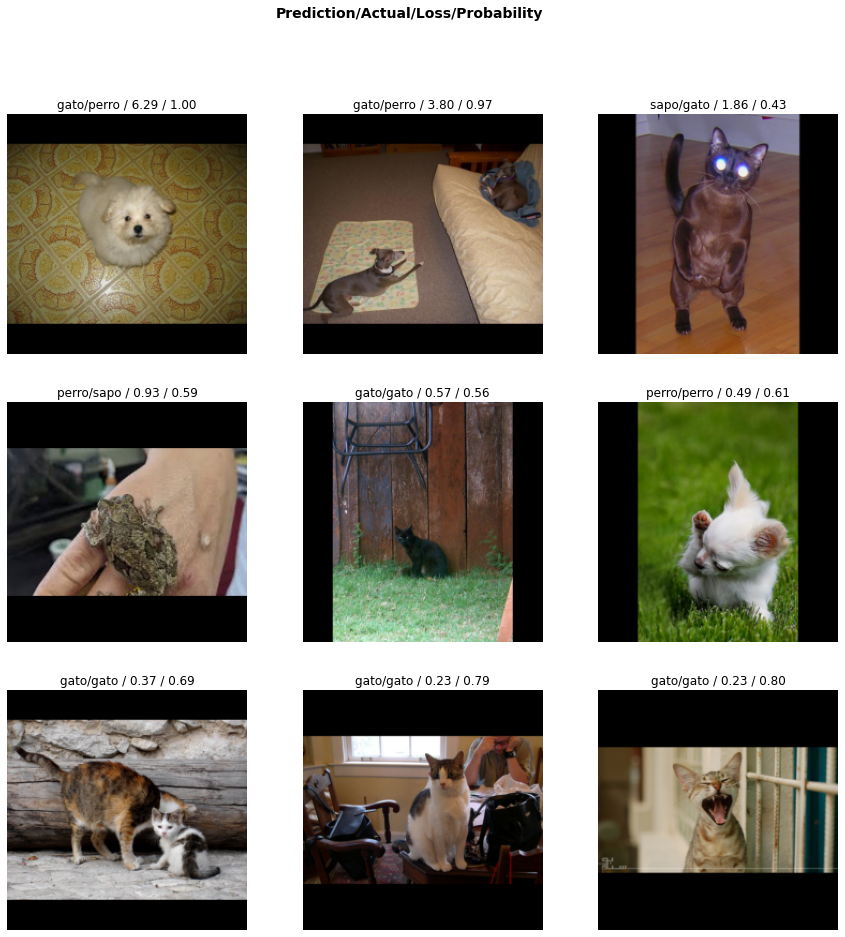

In [13]:
#vemos cuales son los que peor anduvieron
interp.plot_top_losses(9, figsize=(15,15))
interp.most_confused(min_val=2)


## Entrenamiento.. Fine tune

In [ ]:
learn.load('best_resnet18')
# Desbloqueamos las capas intermedias... asi ajustamos los cnns a nuestras fotos
learn.unfreeze()
#buscamos.. cual seria el lr optimo


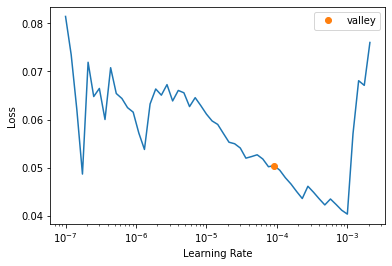

In [16]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    #plot
    # model.recorder.plot()
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

optimal_lr = find_appropriate_lr(learn)
# optimal_lr=0.01

In [17]:
learn.fit_one_cycle(5, lr_max=slice(optimal_lr/10, optimal_lr), cbs=cbs)


epoch,train_loss,valid_loss,error_rate,time
0,0.044082,0.068903,0.022901,00:14
1,0.036301,0.064710,0.019084,00:14
2,0.036327,0.060620,0.019084,00:14
3,0.029577,0.064266,0.022901,00:14
4,0.022168,0.064485,0.019084,00:14


Better model found at epoch 0 with valid_loss value: 0.06890256702899933.
Better model found at epoch 1 with valid_loss value: 0.06470959633588791.
Better model found at epoch 2 with valid_loss value: 0.06062014400959015.


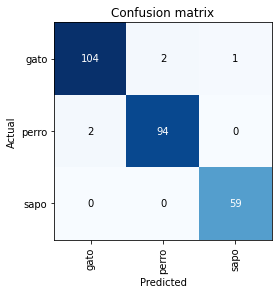

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
losses,idxs = interp.top_losses()
# len(data.valid_ds)==len(losses)==len(idxs)

[('gato', 'perro', 2), ('perro', 'gato', 2)]

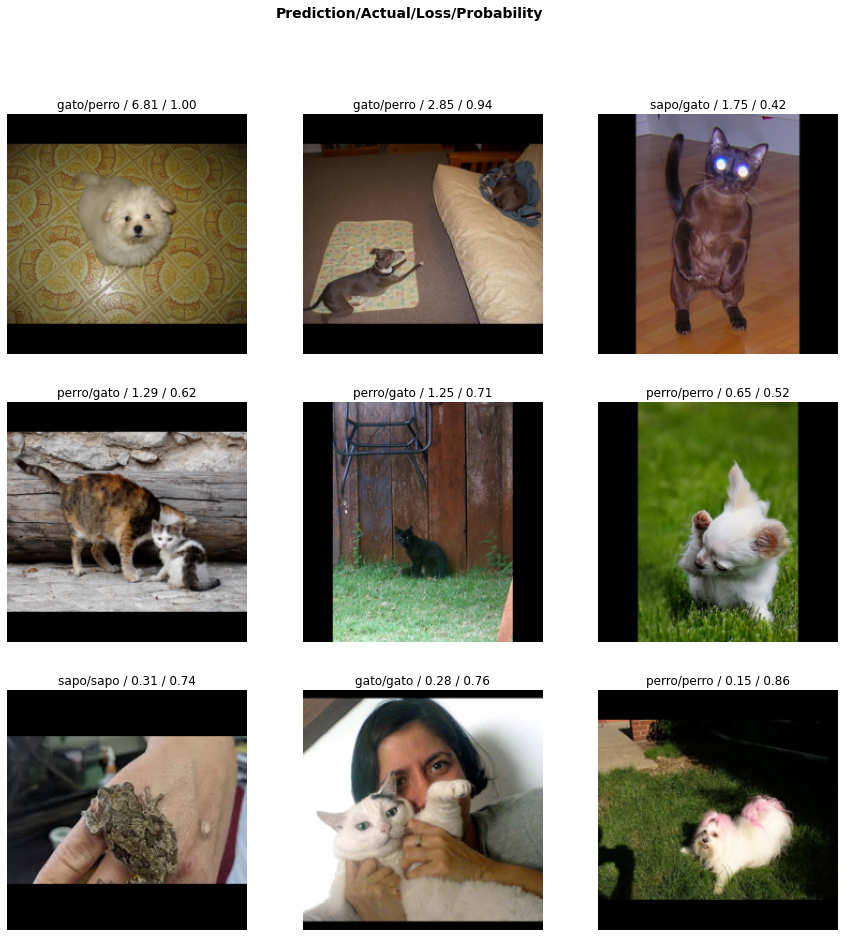

In [19]:
#vemos cuales son los que peor anduvieron
interp.plot_top_losses(9, figsize=(15,15))
interp.most_confused(min_val=2)


In [ ]:
#no ejecutar... borrar...
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
hace.. mas o menos lo mismo que...    
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

## Guardamos!

In [20]:
learn.export('clasificador.pkl')

### prueba de inferencia..

In [ ]:
learn = load_learner('clasificador.pkl')


In [21]:
imagen = "/content/data/perro/n02085620_275.jpg"
learn.predict(imagen)

('perro', tensor(1), tensor([5.1042e-03, 9.9473e-01, 1.6819e-04]))